<a href="https://colab.research.google.com/github/Cp557/app_review_analysis/blob/main/app_review_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 Mobile App Review Analysis with BigQuery & Vertex AI

## Introduction
Understanding user feedback is critical for improving mobile applications and enhancing customer satisfaction. This project leverages BigQuery, Vertex AI, and data visualization to explore and analyze mobile app reviews.

The workflow includes:
- **Data Cleaning**: Handling missing values, normalizing app versions, and imputing ratings using AI-generated estimates.  
- **Exploratory Data Analysis (EDA)**: Visualizing the most reviewed apps, distribution of ratings, country-wise averages, and identifying top and bottom performers.  
- **AI-Powered Insights**: Using Gemini models to summarize user sentiment, extract key themes, and recommend actionable improvements.  
- **Embedding & Chatbot**: Creating vector representations of reviews to power semantic search, enabling natural language queries. This allows product managers to ask questions like *“Which apps have too many ads?”* and receive context-driven insights.  

By combining traditional analytics with generative AI, this notebook provides a powerful toolkit for product teams, data analysts, and app developers to better understand user sentiment, identify pain points, and drive product enhancements.

In [ ]:
!pip install -q --upgrade bigframes google-cloud-bigquery gradio

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.cloud import bigquery
import plotly.express as px

In [ ]:
PROJECT_ID = "mobile-app-review-471616"
DATASET = "reviews"
TABLE   = "app reviews"
VERTEX_CONNECTION = "projects/mobile-app-review-471616/locations/us-central1/connections/bigquery_ai"
bq = bigquery.Client(project=PROJECT_ID)

# Data Cleaning and EDA

In [ ]:
query = f"""
SELECT
  COUNTIF(review_id IS NULL) AS missing_review_id,
  COUNTIF(user_id IS NULL) AS missing_user_id,
  COUNTIF(app_name IS NULL) AS missing_app_name,
  COUNTIF(app_category IS NULL) AS missing_app_category,
  COUNTIF(review_text IS NULL OR review_text = '') AS missing_review_text,
  COUNTIF(review_language IS NULL) AS missing_review_language,
  COUNTIF(rating IS NULL) AS missing_rating,
  COUNTIF(review_date IS NULL) AS missing_review_date,
  COUNTIF(verified_purchase IS NULL) AS missing_verified_purchase,
  COUNTIF(device_type IS NULL) AS missing_device_type,
  COUNTIF(num_helpful_votes IS NULL) AS missing_num_helpful_votes,
  COUNTIF(user_age IS NULL) AS missing_user_age,
  COUNTIF(user_country IS NULL OR user_country = '') AS missing_user_country,
  COUNTIF(user_gender IS NULL OR user_gender = '') AS missing_user_gender,
  COUNTIF(app_version IS NULL OR app_version = '') AS missing_app_version
FROM `{PROJECT_ID}.{DATASET}.{TABLE}`;
"""

df_missing_counts = bq.query(query).to_dataframe()
df_missing_counts

,missing_review_id,missing_user_id,missing_app_name,missing_app_category,missing_review_text,missing_review_language,missing_rating,missing_review_date,missing_verified_purchase,missing_device_type,missing_num_helpful_votes,missing_user_age,missing_user_country,missing_user_gender,missing_app_version
0,0,0,0,0,59,0,37,0,0,0,0,0,41,587,30


In [ ]:
# -- Cleaning the Mobile App Review Dataset
# -- --------------------------------------
# -- 1. Drop rows where review_text is empty or app_version is missing
# -- 2. Impute missing rating with AI.GENERATE_INT(...).result (1–5) based on review_text
# -- 3. Replace missing user_gender and user_country with 'Unknown'
# -- 4. Remove leading 'v' from app_version (e.g., v10.9.10 → 10.9.10)
# -- 5. Drop the app_category column (since it is unreliable)

query = f"""
CREATE OR REPLACE TABLE {PROJECT_ID}.{DATASET}.cleaned_reviews AS
SELECT
  review_id,
  user_id,
  app_name,
  review_text,
  review_language,
  COALESCE(
    rating,
    AI.GENERATE_DOUBLE(
      ('Guess a star rating between 1.0 and 5.0 with exactly one decimal place '
       'based ONLY on this review. Example outputs: 1.0, 2.5, 3.3, 5.0. '
       'Return just the number with one decimal place: "', review_text, '"'),
      connection_id => '{VERTEX_CONNECTION}',
      endpoint => 'gemini-2.0-flash'
    ).result
  ) AS rating,
  review_date,
  verified_purchase,
  device_type,
  num_helpful_votes,
  user_age,
  IFNULL(user_country, 'Unknown') AS user_country,
  IFNULL(user_gender, 'Unknown') AS user_gender,
  REGEXP_REPLACE(app_version, r'^v', '') AS app_version
FROM `{PROJECT_ID}.{DATASET}.{TABLE}`
WHERE review_text IS NOT NULL AND review_text != ''
  AND app_version IS NOT NULL;
"""

In [ ]:
job = bq.query(query)
job.result()  # waits for the query to finish
print("✅ Cleaned table created successfully!")
CLEANED_TABLE = 'cleaned_reviews'

✅ Cleaned table created successfully!


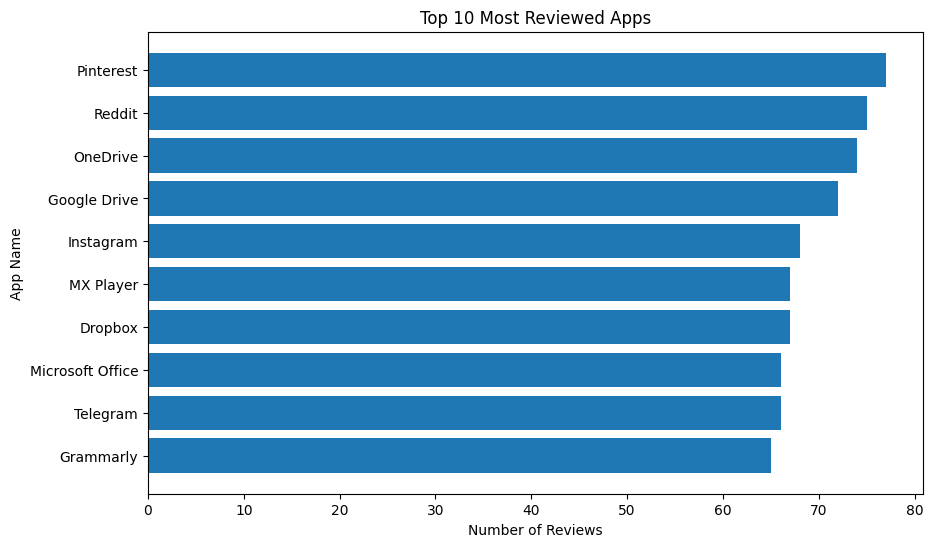

In [ ]:
query_top_apps = f"""
SELECT app_name, COUNT(*) AS review_count
FROM `{PROJECT_ID}.{DATASET}.{CLEANED_TABLE}`
GROUP BY app_name
ORDER BY review_count DESC
LIMIT 10
"""
df_top_apps = bq.query(query_top_apps).to_dataframe()

plt.figure(figsize=(10,6))
plt.barh(df_top_apps['app_name'], df_top_apps['review_count'])
plt.xlabel("Number of Reviews")
plt.ylabel("App Name")
plt.title("Top 10 Most Reviewed Apps")
plt.gca().invert_yaxis()  # Largest bar at top
plt.show()

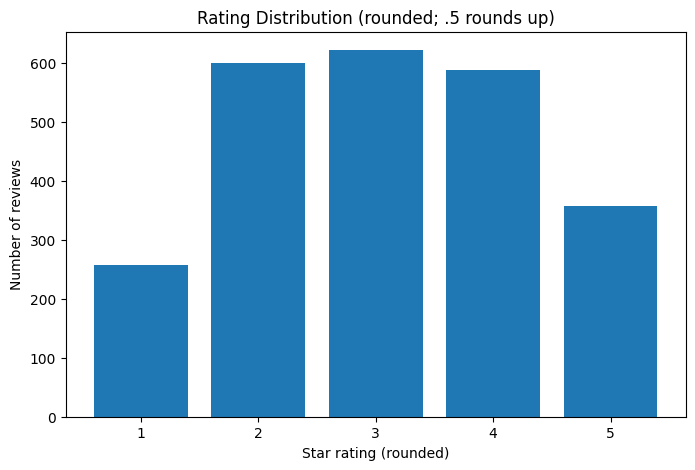

In [ ]:
query_rating_dist = f"""
SELECT
  CAST(GREATEST(1, LEAST(5, FLOOR(CAST(rating AS FLOAT64) + 0.5))) AS INT64) AS rounded_rating,
  COUNT(*) AS n
FROM `{PROJECT_ID}.{DATASET}.{CLEANED_TABLE}`
GROUP BY rounded_rating
"""

df_rating = bq.query(query_rating_dist).to_dataframe()

# Ensure all 1..5 buckets exist (even if zero)
all_ratings = pd.DataFrame({'rounded_rating': [1, 2, 3, 4, 5]})
df_rating = (all_ratings
             .merge(df_rating, on='rounded_rating', how='left')
             .fillna({'n': 0})
             .sort_values('rounded_rating'))

plt.figure(figsize=(8,5))
plt.bar(df_rating['rounded_rating'].astype(str), df_rating['n'])
plt.xlabel("Star rating (rounded)")
plt.ylabel("Number of reviews")
plt.title("Rating Distribution (rounded; .5 rounds up)")
plt.show()

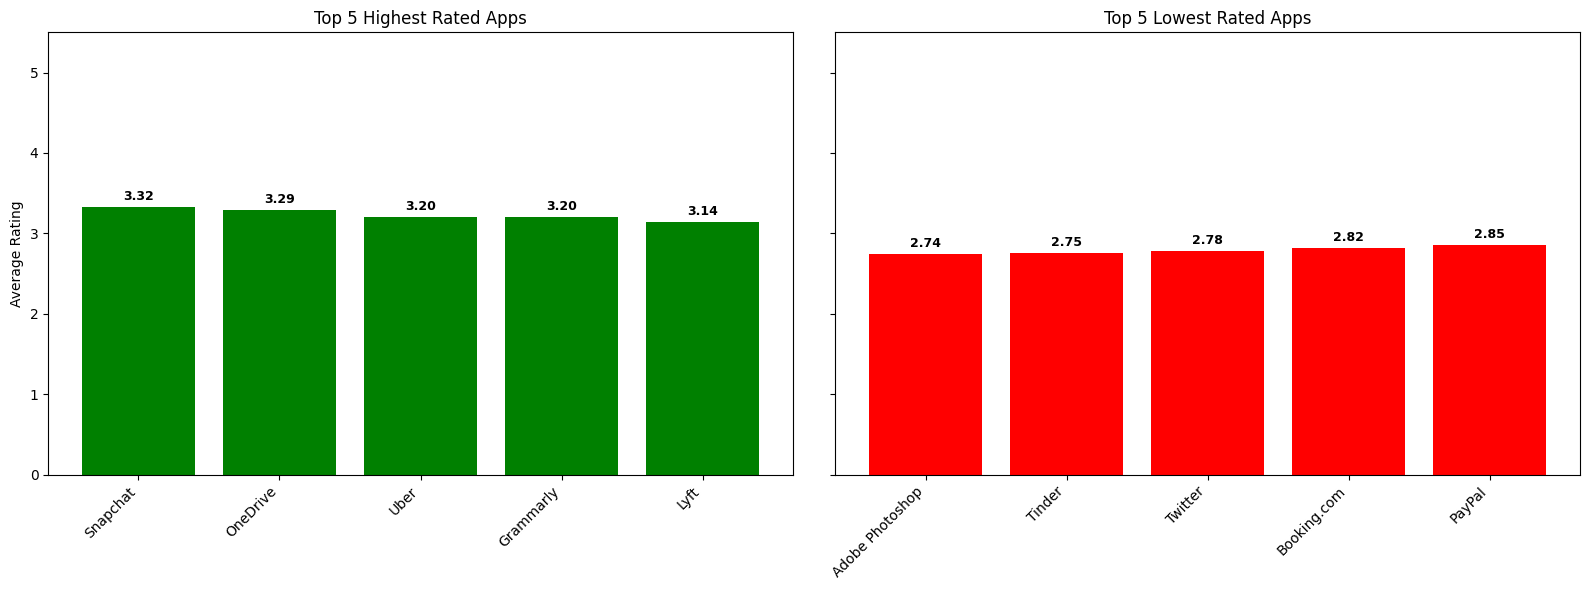

In [ ]:
query_app_ratings = f"""
SELECT
  app_name,
  AVG(CAST(rating AS FLOAT64)) AS avg_rating,
  COUNT(*) AS n_reviews
FROM `{PROJECT_ID}.{DATASET}.{CLEANED_TABLE}`
GROUP BY app_name
HAVING n_reviews > 10   -- filter out apps with very few reviews (optional)
"""

df_apps = bq.query(query_app_ratings).to_dataframe()

# Top 5 and bottom 5
df_top5 = df_apps.sort_values("avg_rating", ascending=False).head(5)
df_bottom5 = df_apps.sort_values("avg_rating", ascending=True).head(5)

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16,6), sharey=True)

# --- Left: Top 5
bars = axes[0].bar(df_top5["app_name"], df_top5["avg_rating"], color="green")
axes[0].set_title("Top 5 Highest Rated Apps")
axes[0].set_ylabel("Average Rating")
axes[0].set_ylim(0, 5.5)
plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right")

for bar, rating in zip(bars, df_top5["avg_rating"]):
    axes[0].text(bar.get_x() + bar.get_width()/2,
                 bar.get_height() + 0.05,
                 f"{rating:.2f}",
                 ha="center", va="bottom", fontsize=9, fontweight="bold")

# --- Right: Bottom 5
bars = axes[1].bar(df_bottom5["app_name"], df_bottom5["avg_rating"], color="red")
axes[1].set_title("Top 5 Lowest Rated Apps")
axes[1].set_ylim(0, 5.5)
plt.setp(axes[1].get_xticklabels(), rotation=45, ha="right")

for bar, rating in zip(bars, df_bottom5["avg_rating"]):
    axes[1].text(bar.get_x() + bar.get_width()/2,
                 bar.get_height() + 0.05,
                 f"{rating:.2f}",
                 ha="center", va="bottom", fontsize=9, fontweight="bold")

plt.tight_layout()
plt.show()

In [ ]:
query_country_avg = f"""
SELECT
  user_country AS country,
  AVG(CAST(rating AS FLOAT64)) AS avg_rating
FROM `{PROJECT_ID}.{DATASET}.{CLEANED_TABLE}`
WHERE user_country IS NOT NULL
  AND user_country != ''
  AND LOWER(user_country) != 'unknown'
GROUP BY country
ORDER BY avg_rating DESC
"""

df_country_avg = bq.query(query_country_avg).to_dataframe()

fig_avg = px.choropleth(
    df_country_avg,
    locations="country",
    locationmode="country names",
    color="avg_rating",
    color_continuous_scale="Viridis",
    range_color=(2.75, 3.25),
    title="Average Rating by Country (1–5)"
)
fig_avg.update_coloraxes(colorbar_title="Avg rating")
fig_avg.show()

# AI-Powered Insights

In [ ]:
create_text_model_sql = f"""
CREATE OR REPLACE MODEL `{PROJECT_ID}.{DATASET}.text_gen_model`
REMOTE WITH CONNECTION `{VERTEX_CONNECTION}`
OPTIONS (ENDPOINT = "gemini-2.5-flash");
"""
bq.query(create_text_model_sql).result()
print("✅ Text generation model created: text_gen_model")

✅ Text generation model created: text_gen_model


In [ ]:
def app_analysis(target_app):
    # Step 1: Pull all reviews for the given app
    review_query = f"""
    SELECT
      review_id,
      review_text,
      rating,
      user_country
    FROM `{PROJECT_ID}.{DATASET}.{CLEANED_TABLE}`
    WHERE app_name = @target_app
      AND review_text IS NOT NULL
      AND review_text != ''
    LIMIT 200  -- safeguard so we don't overload context
    """

    job_config = bigquery.QueryJobConfig(
        query_parameters=[
            bigquery.ScalarQueryParameter("target_app", "STRING", target_app)
        ]
    )
    reviews_df = bq.query(review_query, job_config=job_config).to_dataframe()

    # Step 2: Build the context text
    context_parts = []
    for idx, review in reviews_df.iterrows():
        context_parts.append(
            f"Review {idx+1} (Rating: {review['rating']}/5, {review['review_text']}"
        )
    context = " ".join(context_parts)

    # Step 3: Use AI.GENERATE to analyze and suggest improvements
    gen_text_query = f"""
    SELECT
      AI.GENERATE(
        ('''
        <role>
        You are a product analyst.
        </role>

        <instructions>
        Analyze the following user reviews for {target_app}.
        If a review is not in English, translate it before considering its content for the analysis.
        Provide:
        1. A high-level summary of user sentiment.
        2. Key recurring themes (positive and negative).
        3. Specific actionable improvements that the product team should prioritize.
        </instructions>

        <context>
        Reviews:
        {context}
        </context>
        '''),
        connection_id => '{VERTEX_CONNECTION}',
        endpoint => 'gemini-2.0-flash'
      ).result AS analysis
    """

    llm_result = bq.query(gen_text_query).to_dataframe()
    return llm_result["analysis"].iloc[0]

In [ ]:
app_name = 'Amazon'  #@param ["YouTube", "Signal", "Pinterest", "Instagram", "eBay", "Microsoft Office", "WhatsApp", "Canva", "Coursera", "Grammarly", "MX Player", "Google Maps", "Reddit", "Twitter", "Discord", "VLC", "Spotify", "Waze", "Facebook", "Udemy", "TikTok", "Google Drive", "OneDrive", "Airbnb", "Telegram", "Netflix", "Amazon", "Uber", "Zoom", "LinkedIn", "Venmo", "Tinder", "Dropbox", "Lyft", "Adobe Photoshop", "Snapchat", "Duolingo", "Bumble", "Khan Academy", "Booking.com", "PayPal"]

print(app_analysis(f"{app_name}"))

Okay, I will analyze the provided user reviews for the Amazon product, focusing on sentiment, key themes, and actionable improvements.

**Translations of Non-English Reviews:**

*   **Review 5:** "Nisi reprehenderit natus porro sint commodi. Perferendis qui amet dignissimos corporis qui libero dolore." - This Latin translates roughly to: "Unless born again, therefore, a sinless trade. Who prefers to adorn bodies with dignified liberty of pain." This seems to be an automatically generated text, and does not contain any relevant feedback about the product.
*   **Review 18:** "Architecto minus quaerat delectus saepe corporis." - This Latin translates roughly to: "Architect or less seeks pleasure often body." This also seems to be automatically generated text, and does not contain any relevant feedback about the product.
*   **Review 30:** "Est tempora et voluptatum quis corrupti sequi." - This Latin translates roughly to: "It is time and who wants to follow corrupt pleasures." This also s

# Embedding & Chatbot

In [ ]:
REMOTE_MODEL = f"`{PROJECT_ID}.{DATASET}.text_embed_model`"
EMBEDDING_TBL = f"`{PROJECT_ID}.{DATASET}.reviews_embeddings`"

create_model_sql = f"""
CREATE OR REPLACE MODEL {REMOTE_MODEL}
REMOTE WITH CONNECTION `{VERTEX_CONNECTION}`
OPTIONS (ENDPOINT = 'text-embedding-005');
"""
bq.query(create_model_sql, location="us-central1").result()
print("✅ Remote model created:", REMOTE_MODEL)

✅ Remote model created: `mobile-app-review-471616.reviews.text_embed_model`


In [ ]:
create_embeddings_sql = f"""
CREATE OR REPLACE TABLE {EMBEDDING_TBL} AS
SELECT
  review_id,
  content AS review_text,
  app_name,
  app_version,
  CAST(review_date AS TIMESTAMP) AS review_date,
  user_country,
  CAST(user_age AS INT64) AS age,
  ml_generate_embedding_result AS embedding
FROM ML.GENERATE_EMBEDDING(
  MODEL {REMOTE_MODEL},
  (
    SELECT
      review_id,
      review_text AS content,
      app_name,
      app_version,
      review_date,
      user_country,
      user_age
    FROM `{PROJECT_ID}.{DATASET}.{CLEANED_TABLE}`
    WHERE review_text IS NOT NULL AND review_text != ''
  ),
  STRUCT(TRUE AS flatten_json_output, 'SEMANTIC_SIMILARITY' AS task_type)
);
"""
bq.query(create_embeddings_sql, location="us-central1").result()
print("✅ Embeddings table created:", EMBEDDING_TBL)

✅ Embeddings table created: `mobile-app-review-471616.reviews.reviews_embeddings`


In [ ]:
def pm_chatbot_generic(user_message, top_k=30):
    # Step 1: Retrieve semantically similar reviews across ALL apps
    search_query = f"""
    WITH query_embedding AS (
      SELECT ml_generate_embedding_result AS query_embed
      FROM ML.GENERATE_EMBEDDING(
        MODEL {REMOTE_MODEL},
        (SELECT @user_message AS content),
        STRUCT(TRUE AS flatten_json_output, 'SEMANTIC_SIMILARITY' AS task_type)
      )
    )
    SELECT
      e.review_text,
      e.app_name,
      c.rating,
      e.user_country
    FROM `{PROJECT_ID}.{DATASET}.reviews_embeddings` e
    CROSS JOIN query_embedding q
    JOIN `{PROJECT_ID}.{DATASET}.{CLEANED_TABLE}` c
      ON e.review_id = c.review_id
    WHERE e.embedding IS NOT NULL
    ORDER BY ML.DISTANCE(e.embedding, q.query_embed, 'COSINE') ASC
    LIMIT {top_k}
    """

    job_config = bigquery.QueryJobConfig(
        query_parameters=[
            bigquery.ScalarQueryParameter("user_message", "STRING", user_message)
        ]
    )
    relevant_reviews = bq.query(search_query, job_config=job_config).to_dataframe()

    # Step 2: Build context string from retrieved reviews
    context_parts = []
    for idx, review in relevant_reviews.iterrows():
        context_parts.append(
            f"Review {idx+1} (App: {review['app_name']}, Rating: {review['rating']}/5, {review['review_text']}"
        )
    context = " ".join(context_parts)

    # Step 3: Ask the LLM to answer the question
    gen_text_query = f"""
    SELECT
      AI.GENERATE(
        ('''
        You are a product analyst. Answer the following user question
        using the information from the reviews below.

        Question:
        {user_message}

        Reviews:
        {context}
        '''),
        connection_id => '{VERTEX_CONNECTION}',
        endpoint => 'gemini-2.0-flash'
      ).result AS answer
    """

    llm_result = bq.query(gen_text_query).to_dataframe()
    return llm_result["answer"].iloc[0]

In [ ]:
response = pm_chatbot_generic("What apps have problems with too many ads and what is the overall sentiment towards these apps.")
print(response)

Based on the reviews provided, the following apps are consistently mentioned as having an issue with too many ads:

*   Amazon
*   Google Maps
*   Microsoft Office
*   VLC
*   WhatsApp
*   Reddit
*   Pinterest
*   OneDrive
*   Khan Academy
*   Booking.com
*   TikTok
*   Venmo
*   Udemy
*   PayPal
*   MX Player
*   Netflix
*   Coursera
*   Facebook
*   Twitter
*   Grammarly
*   Canva
*   Spotify

**Overall Sentiment:**

The overall sentiment towards these apps is mixed. While users generally describe the apps as "Great", their ratings are affected by the prevalence of ads. The ratings vary widely, indicating that the impact of ads is subjective and may depend on the specific app's functionality and user expectations. However, the reviews also suggest that the apps should be considered with a premium version.


